# Urban Heat Island (UHI) Benchmark Notebook 

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [24]:
!pip install geopandas
!pip install pystac_client


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Ng Hui Shi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Ng Hui Shi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [25]:
pip install matplotlib seaborn xarray rioxarray geopandas scikit-learn pystac-client planetary_computer tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm



In [88]:
# import building footprint kml file 
import geopandas as gpd
import zipfile 
import os 
#import fiona 
#from bs4 import BeautifulSoup

building_footprint = gpd.read_file("Building_Footprint.kml", driver='libkml')
building_footprint

,Name,Description,geometry
0,,,"MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4..."
1,,,"MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ..."
2,,,"MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4..."
3,,,"MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4..."
4,,,"MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ..."
...,...,...,...
9431,,,"MULTIPOLYGON (((-73.95267 40.77923, -73.95254 ..."
9432,,,"MULTIPOLYGON (((-73.94964 40.77613, -73.94931 ..."
9433,,,"MULTIPOLYGON (((-73.9521 40.7688, -73.95174 40..."
9434,,,"MULTIPOLYGON (((-73.9523 40.75904, -73.95246 4..."


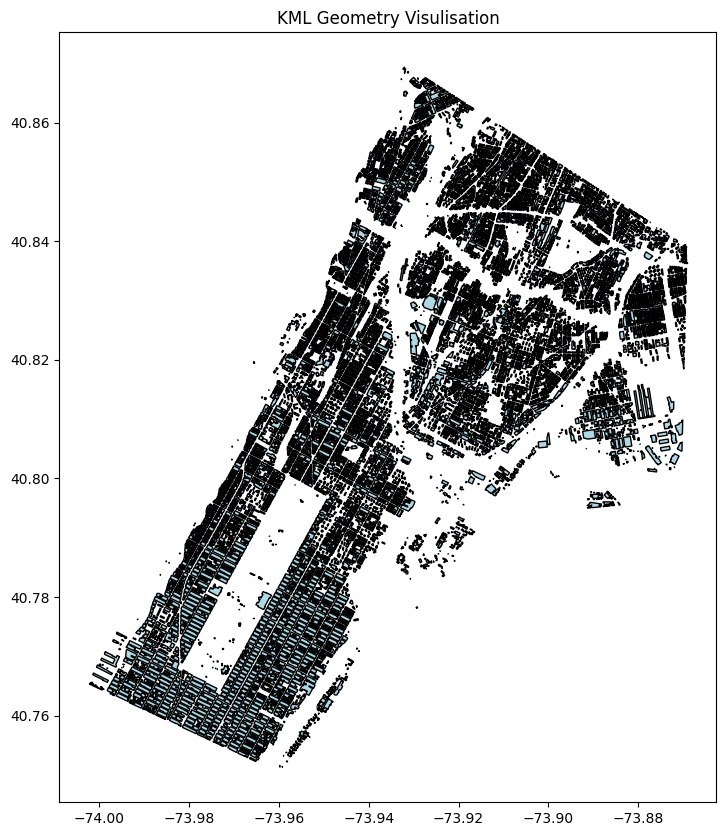

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
building_footprint.plot(ax=ax, edgecolor='black', facecolor='lightblue')

ax.set_title("KML Geometry Visulisation")
plt.show()

In [99]:
# compute numerical features 
building_footprint['area'] = building_footprint.geometry.area
building_footprint["perimeter"] = building_footprint.geometry.length  # Perimeter of each footprint
building_footprint["compactness"] = building_footprint["area"] / building_footprint["perimeter"]  # Compactness ratio
building_footprint["centroid_x"] = building_footprint.geometry.centroid.x  # Longitude of centroid
building_footprint["centroid_y"] = building_footprint.geometry.centroid.y  # Latitude of centroid
building_footprint['centroid'] = building_footprint.geometry.centroid
building_footprint.head()


,Name,Description,geometry,area,perimeter,compactness,centroid_x,centroid_y,centriod,centroid
0,,,"MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4...",6.621750e-08,0.001288,0.000051,-73.919273,40.848097,POINT (-73.91927 40.8481),POINT (-73.91927 40.8481)
1,,,"MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ...",1.017900e-08,0.000454,0.000022,-73.921858,40.849619,POINT (-73.92186 40.84962),POINT (-73.92186 40.84962)
2,,,"MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4...",1.509400e-08,0.000575,0.000026,-73.920382,40.850091,POINT (-73.92038 40.85009),POINT (-73.92038 40.85009)
3,,,"MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4...",8.512000e-09,0.000448,0.000019,-73.920465,40.851392,POINT (-73.92047 40.85139),POINT (-73.92047 40.85139)
4,,,"MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ...",2.309100e-08,0.000619,0.000037,-73.912466,40.852192,POINT (-73.91247 40.85219),POINT (-73.91247 40.85219)


In [105]:
# want to map the building compactness value to the uhi index dataset, based on the nearest coordinates
# of long,lat to centroidx, centriody 

ground_df = pd.read_csv("Training_data_uhi_index_2025-02-18.csv")
ground_df.head()
uhi_gdf = gpd.GeoDataFrame(
    ground_df, 
    geometry=gpd.points_from_xy(ground_df['Longitude'], ground_df['Latitude']),
    crs='EPSG:4326'
)

building_footprint = building_footprint[['centroid','centroid_x', 'centroid_y', 'compactness']]
centroid_gdf = building_footprint.set_geometry('centroid')


In [106]:
# perform spatial join to match 
uhi_gdf = uhi_gdf.sjoin_nearest(centroid_gdf, how='left', distance_col='nearest_distance')
uhi_gdf.head()

,Longitude,Latitude,datetime,UHI Index,geometry,index_right,centroid_x,centroid_y,compactness,nearest_distance
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,POINT (-73.90917 40.81311),2024,-73.909395,40.813539,0.000031,0.000489
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,POINT (-73.90919 40.81304),2024,-73.909395,40.813539,0.000031,0.000536
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,POINT (-73.90922 40.81298),3525,-73.908864,40.812506,0.000098,0.000588
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,POINT (-73.90924 40.81291),3525,-73.908864,40.812506,0.000098,0.000551
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,POINT (-73.90926 40.81284),3525,-73.908864,40.812506,0.000098,0.000518


In [268]:
ground_df = uhi_gdf[['Longitude', 'Latitude', 'datetime', 'UHI Index', 'compactness']]
ground_df.head()

,Longitude,Latitude,datetime,UHI Index,compactness
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.000031
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.000031
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.000098
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.000098
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.000098


## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

<h10 style="color:rgb(255, 255, 0)"><strong>Note: Participants are strictly prohibited from using Longitude and Latitude values as features in building their machine learning models. These values should only be utilized for understanding the attributes and characteristics of the locations. Submissions that employ longitude and latitude values as model features will be disqualified.</strong></h10>

<h10 style="color:rgb(255, 255, 0)"><strong>Incorporating latitude and longitude data in their raw forms or through any form of manipulation—including multiplication, embedding, or conversion to polar coordinates—as predictive features in your model is strictly prohibited, as it can compromise the adaptability of your model across diverse scenarios. This prohibition extends to calculating the distance from a reference point and using it as a feature, which is essentially a transformation of the original geographical coordinates into a new feature form. Submissions that include these types of features will be considered non-compliant and will be disqualified.</strong></h10>

In [ ]:
# Load the training data from csv file and display the first few rows to inspect the data
# ground_df = pd.read_csv("Training_data_uhi_index_2025-02-18.csv")
# ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul> 
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image. 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

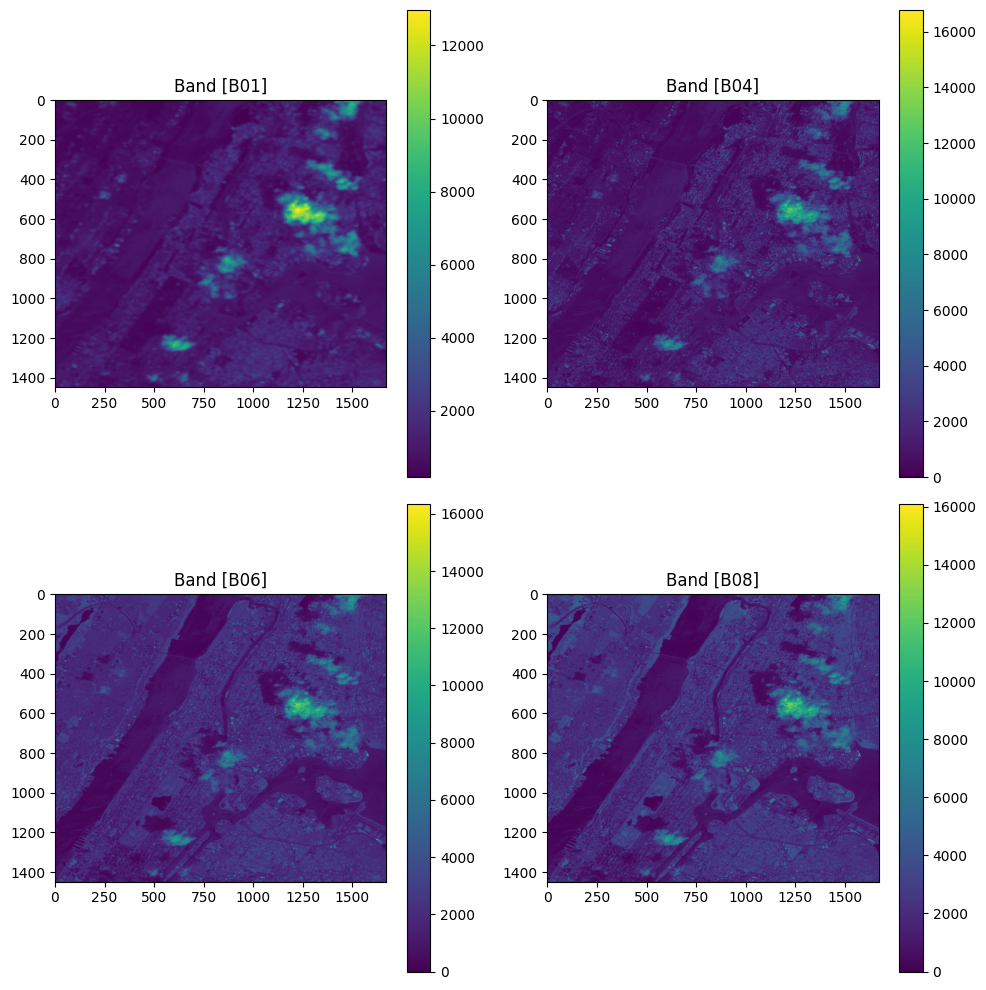

In [269]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "S2_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()


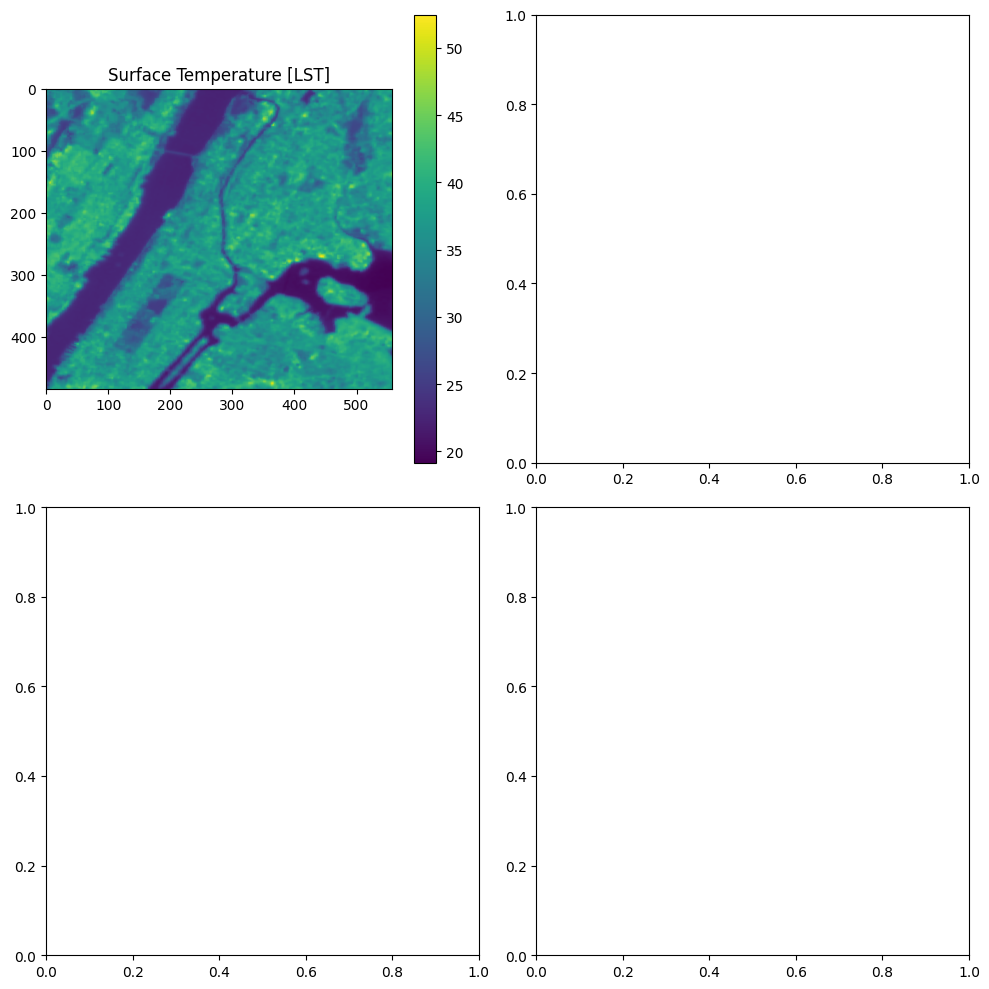

In [270]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file # landsat LST dataset 
tiff_path1 = "Landsat_LST.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path1) as src1:
    band1 = src1.read(1)  # Band [B01]
    #band2 = src1.read(2)  # Band [B04]
    #band3 = src1.read(3)  # Band [B06]
    #band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Surface Temperature [LST]')
fig.colorbar(im1, ax=axes[0])

plt.tight_layout()
plt.show()


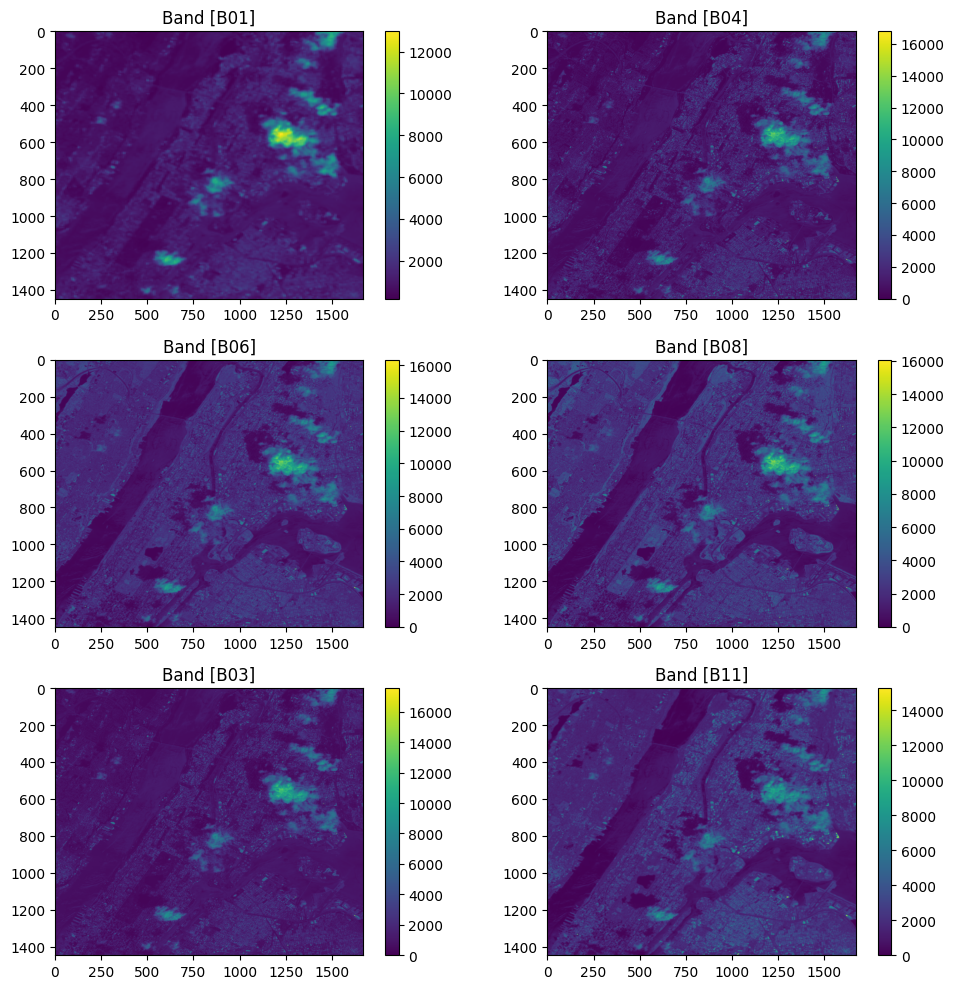

In [198]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "S2_sample1.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]
    band5 = src1.read(5)  # Band [B03]
    band6 = src1.read(6)  # Band [B11] 

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

im5 = axes[4].imshow(band5, cmap='viridis')
axes[4].set_title('Band [B03]')
fig.colorbar(im5, ax=axes[4])

im6 = axes[5].imshow(band6, cmap='viridis')
axes[5].set_title('Band [B11]')
fig.colorbar(im6, ax=axes[5])

plt.tight_layout()
plt.show()


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [271]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B03_values = []
    B04_values = []
    B06_values = []
    B08_values = []
    B11_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)
    
        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)
        
        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)
    
        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)

        B03_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        B03_values.append(B03_value)

        B11_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        B11_values.append(B11_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B04'] = B04_values
    df['B06'] = B06_values
    df['B08'] = B08_values
    df['B03'] = B03_values 
    df['B11'] = B11_values
    
    return df


In [330]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.
# geo_sample2 tiff file
def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B04_values = []
    B06_values = []
    B08_values = []
    B12_values = []
    B11_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)
    
        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)
        
        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)
    
        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)

        B12_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        B12_values.append(B12_value)

        B11_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        B11_values.append(B11_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B04'] = B04_values
    df['B06'] = B06_values
    df['B08'] = B08_values
    df['B12'] = B12_values 
    df['B11'] = B11_values
    
    return df


In [272]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.
# try to perform on land surface temperature file 

def map_satellite_data1(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    LST_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        LST_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        LST_values.append(LST_value)


    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['LST'] = LST_values
    
    
    return df


In [331]:
final_data1 = map_satellite_data1('Landsat_LST.tiff', 'Training_data_uhi_index_2025-02-18.csv')

Mapping values:   0%|          | 0/11229 [00:00<?, ?it/s]

Mapping values: 100%|██████████| 11229/11229 [00:19<00:00, 589.45it/s]


In [332]:
final_data1.head(10)

,LST
0,38.393941100000006
1,38.393941100000006
2,37.78553354000002
3,37.78553354000002
4,37.35828104000001
5,37.35828104000001
6,37.35828104000001
7,37.35828104000001
8,37.09167548000005
9,37.09167548000005


In [333]:
# Mapping satellite data with training data.
final_data = map_satellite_data('S2_sample2.tiff', 'Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [02:03<00:00, 91.12it/s]


In [334]:
final_data.head()

,B01,B04,B06,B08,B12,B11
0,846.0,1036.0,1502.0,1906.0,1265.0,1487.0
1,846.0,1036.0,1502.0,1906.0,1265.0,1487.0
2,846.0,709.0,1668.0,2190.0,991.0,1465.0
3,846.0,657.0,1668.0,2182.0,991.0,1465.0
4,846.0,745.0,1728.0,2112.0,1134.0,1544.0


In [335]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

In [278]:
# Calculate NDBI (Normalized Difference Building Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NVBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NVBI'] = final_data['NVBI'].replace([np.inf, -np.inf], np.nan)

In [279]:
# Calculate NDWI (Normalized Difference Water Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NVWI'] = (final_data['B03'] - final_data['B08']) / (final_data['B03'] + final_data['B08'])
final_data['NVWI'] = final_data['NVWI'].replace([np.inf, -np.inf], np.nan)

In [119]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [457]:
# import local weather data from xlsx 
weather_bronx = pd.read_excel('NY_Mesonet_Weather.xlsx', sheet_name='Bronx')
weather_manhattan = pd.read_excel('NY_Mesonet_Weather.xlsx', sheet_name='Manhattan')
weather_bronx['nysm_long'] = -73.89352
weather_bronx['nysm_lat'] = 40.87248
weather_bronx['station'] = 'Bronx'
weather_manhattan['nysm_long'] = -73.96449
weather_manhattan['nysm_lat'] = 40.76754
weather_manhattan['station'] = 'Manhattan'
weather_bronx.head()

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],nysm_long,nysm_lat,station
0,2021-07-24 06:00:00 EDT,19.3,88.2,0.8,335,12,-73.89352,40.87248,Bronx
1,2021-07-24 06:05:00 EDT,19.4,87.9,0.8,329,18,-73.89352,40.87248,Bronx
2,2021-07-24 06:10:00 EDT,19.3,87.6,0.7,321,25,-73.89352,40.87248,Bronx
3,2021-07-24 06:15:00 EDT,19.4,87.4,0.5,307,33,-73.89352,40.87248,Bronx
4,2021-07-24 06:20:00 EDT,19.4,87.0,0.2,301,42,-73.89352,40.87248,Bronx


In [458]:
weather_manhattan.head()

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],nysm_long,nysm_lat,station
0,2021-07-24 06:00:00 EDT,21.3,66.5,0.9,348,10,-73.96449,40.76754,Manhattan
1,2021-07-24 06:05:00 EDT,21.4,66.1,1.1,345,12,-73.96449,40.76754,Manhattan
2,2021-07-24 06:10:00 EDT,21.4,66.5,1.3,4,14,-73.96449,40.76754,Manhattan
3,2021-07-24 06:15:00 EDT,21.5,65.4,1.3,5,17,-73.96449,40.76754,Manhattan
4,2021-07-24 06:20:00 EDT,21.5,65.0,1.5,346,19,-73.96449,40.76754,Manhattan


In [470]:
weather_data = pd.concat([weather_bronx, weather_manhattan], axis=0) # join datasets by stacking the rows 
# change dat/time column to DT format 
weather_data['Date / Time'] = pd.to_datetime(weather_data['Date / Time'], format='%Y-%m-%d %H:%M:%S EDT')
ground_df['datetime'] = pd.to_datetime(ground_df['datetime'], format='mixed')
bronx_lat = 40.87248
manhattan_lat = 40.76754
# create new column station in ground_df to determine station for local weatehr data 
ground_df['station'] = ground_df['Latitude'].apply(lambda x: 'Bronx' if abs(x - bronx_lat) < abs(x - manhattan_lat) else 'Manhattan')
print(ground_df.head())
weather_data.head(10)

   Longitude   Latitude            datetime  UHI Index  compactness    station
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289     0.000031  Manhattan
1 -73.909187  40.813045 2021-07-24 15:53:00   1.030289     0.000031  Manhattan
2 -73.909215  40.812978 2021-07-24 15:53:00   1.023798     0.000098  Manhattan
3 -73.909242  40.812908 2021-07-24 15:53:00   1.023798     0.000098  Manhattan
4 -73.909257  40.812845 2021-07-24 15:53:00   1.021634     0.000098  Manhattan


,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],nysm_long,nysm_lat,station
0,2021-07-24 06:00:00,19.3,88.2,0.8,335,12,-73.89352,40.87248,Bronx
1,2021-07-24 06:05:00,19.4,87.9,0.8,329,18,-73.89352,40.87248,Bronx
2,2021-07-24 06:10:00,19.3,87.6,0.7,321,25,-73.89352,40.87248,Bronx
3,2021-07-24 06:15:00,19.4,87.4,0.5,307,33,-73.89352,40.87248,Bronx
4,2021-07-24 06:20:00,19.4,87.0,0.2,301,42,-73.89352,40.87248,Bronx
5,2021-07-24 06:25:00,19.4,85.1,0.3,64,53,-73.89352,40.87248,Bronx
6,2021-07-24 06:30:00,19.4,84.3,0.2,56,65,-73.89352,40.87248,Bronx
7,2021-07-24 06:35:00,19.4,83.7,0.4,56,78,-73.89352,40.87248,Bronx
8,2021-07-24 06:40:00,19.4,83.2,0.8,40,91,-73.89352,40.87248,Bronx
9,2021-07-24 06:45:00,19.4,82.5,1.1,39,103,-73.89352,40.87248,Bronx


In [478]:
# filter out time between 3pm-4pm
weather_data['Date / Time'] = pd.to_datetime(weather_data['Date / Time'])
weather_data_filtered = weather_data[weather_data['Date / Time'].dt.hour == 15]
weather_data_filtered.head()

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],nysm_long,nysm_lat,station
108,2021-07-24 15:00:00,28.0,40.3,3.0,75,725,-73.89352,40.87248,Bronx
109,2021-07-24 15:05:00,28.1,40.2,1.7,92,558,-73.89352,40.87248,Bronx
110,2021-07-24 15:10:00,28.3,40.3,2.9,91,216,-73.89352,40.87248,Bronx
111,2021-07-24 15:15:00,28.0,40.7,3.1,114,236,-73.89352,40.87248,Bronx
112,2021-07-24 15:20:00,27.9,41.8,2.8,105,229,-73.89352,40.87248,Bronx


In [481]:
# Group the data by 'station' and aggregate by calculating the mean for each column
weather_data_aggregated = weather_data_filtered.groupby('station').agg({
    'Air Temp at Surface [degC]': 'mean',
    'Relative Humidity [percent]': 'mean',
    'Avg Wind Speed [m/s]': 'mean',
    'Wind Direction [degrees]': 'mean',
    'Solar Flux [W/m^2]': 'mean',
    'nysm_long': 'first',  # Taking the first value for longitude (or use mean if necessary)
    'nysm_lat': 'first',   # Taking the first value for latitude (or use mean if necessary)
}).reset_index()

weather_data_aggregated.columns = ['Station', 'Temp_C', 'Humidity', 'Wind_Speed_m_s', 'Wind_Direction_deg', 'Solar_Flux_W_m2', 'Longitude', 'Latitude']

# Check the first few rows of the aggregated data
weather_data_aggregated.head()

,Station,Temp_C,Humidity,Wind_Speed_m_s,Wind_Direction_deg,Solar_Flux_W_m2,Longitude,Latitude
0,Bronx,27.516667,44.458333,3.125000,132.666667,454.916667,-73.89352,40.87248
1,Manhattan,26.733333,48.541667,2.966667,167.916667,426.083333,-73.96449,40.76754


In [550]:
# Haversine Formula: calculate great-circle distance btw 2 points of Earth's surface
# given longitude and latitude 

# Haversine formula to calculate distance between two points on the earth's surface
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Function to calculate weighted average based on proximity to stations
def weighted_weather(row, weather_data):
    # Calculate distances to each station
    distances = []
    for _, station in weather_data.iterrows():
        distance = haversine(row['Latitude'], row['Longitude'], station['Latitude'], station['Longitude'])
        distances.append(distance)
    
    # Inverse of distances (for weighting)
    inverse_distances = [1 / distance if distance > 0 else 0 for distance in distances]
    
    # Normalize the weights (so they sum to 1)
    total_weight = sum(inverse_distances)
    normalized_weights = [weight / total_weight for weight in inverse_distances]
    
    # Compute the weighted averages
    weighted_values = {}
    for col in ['Temp_C', 'Humidity', 'Wind_Speed_m_s', 'Wind_Direction_deg', 'Solar_Flux_W_m2']:
        weighted_values[col] = sum(weather_data[col] * normalized_weights)
    
    return weighted_values

# Apply the weighted average function to each row of the training data
def merge_weather_data(training_data, weather_data):
    weather_data_merged = []
    for _, row in training_data.iterrows():
        weighted_weather_values = weighted_weather(row, weather_data)
        weather_data_merged.append({**row.to_dict(), **weighted_weather_values})
    
    # Convert the result to a DataFrame
    return pd.DataFrame(weather_data_merged)

# Merge the weather data onto the training dataset
merged_data = merge_weather_data(ground_df, weather_data_aggregated)

# View the first few rows of the merged data
merged_data = merged_data[['Temp_C', 'Humidity', 'Wind_Speed_m_s', 'Wind_Direction_deg', 'Solar_Flux_W_m2']]
merged_data

,Temp_C,Humidity,Wind_Speed_m_s,Wind_Direction_deg,Solar_Flux_W_m2
0,27.129322,46.477470,3.046707,150.097170,440.659092
1,27.128941,46.479456,3.046630,150.114321,440.645063
2,27.128515,46.481677,3.046544,150.133494,440.629380
3,27.128074,46.483975,3.046455,150.153329,440.613156
4,27.127695,46.485953,3.046378,150.170403,440.599189
...,...,...,...,...,...
11224,26.888336,47.733674,2.997997,160.941543,431.788754
11225,26.888160,47.734592,2.997961,160.949471,431.782269
11226,26.887876,47.736073,2.997904,160.962254,431.771812
11227,26.887745,47.736757,2.997877,160.968160,431.766982


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [551]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [552]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data = combine_two_datasets(uhi_data, final_data1)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,compactness,station,B01,B04,B06,B08,B12,B11,NDVI,LST
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,0.000031,Manhattan,846.0,1036.0,1502.0,1906.0,1265.0,1487.0,0.295717,38.393941100000006
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,0.000031,Manhattan,846.0,1036.0,1502.0,1906.0,1265.0,1487.0,0.295717,38.393941100000006
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,0.000098,Manhattan,846.0,709.0,1668.0,2190.0,991.0,1465.0,0.510866,37.78553354000002
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,0.000098,Manhattan,846.0,657.0,1668.0,2182.0,991.0,1465.0,0.537161,37.78553354000002
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,0.000098,Manhattan,846.0,745.0,1728.0,2112.0,1134.0,1544.0,0.478474,37.35828104000001


In [554]:
uhi_data_2 = combine_two_datasets(uhi_data, merged_data)
uhi_data_2.head()

,Longitude,Latitude,datetime,UHI Index,compactness,station,B01,B04,B06,B08,B12,B11,NDVI,LST,Temp_C,Humidity,Wind_Speed_m_s,Wind_Direction_deg,Solar_Flux_W_m2
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,0.000031,Manhattan,846.0,1036.0,1502.0,1906.0,1265.0,1487.0,0.295717,38.393941100000006,27.129322,46.477470,3.046707,150.097170,440.659092
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289,0.000031,Manhattan,846.0,1036.0,1502.0,1906.0,1265.0,1487.0,0.295717,38.393941100000006,27.128941,46.479456,3.046630,150.114321,440.645063
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,0.000098,Manhattan,846.0,709.0,1668.0,2190.0,991.0,1465.0,0.510866,37.78553354000002,27.128515,46.481677,3.046544,150.133494,440.629380
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,0.000098,Manhattan,846.0,657.0,1668.0,2182.0,991.0,1465.0,0.537161,37.78553354000002,27.128074,46.483975,3.046455,150.153329,440.613156
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,0.000098,Manhattan,846.0,745.0,1728.0,2112.0,1134.0,1544.0,0.478474,37.35828104000001,27.127695,46.485953,3.046378,150.170403,440.599189


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [498]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01','B04','B06','B08', 'B12', 'B11', 'NDVI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()


,Longitude,Latitude,datetime,UHI Index,compactness,station,B01,B04,B06,B08,B12,B11,NDVI,LST
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,0.000031,Manhattan,846.0,1036.0,1502.0,1906.0,1265.0,1487.0,0.295717,38.393941100000006
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,0.000098,Manhattan,846.0,709.0,1668.0,2190.0,991.0,1465.0,0.510866,37.78553354000002
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,0.000098,Manhattan,846.0,657.0,1668.0,2182.0,991.0,1465.0,0.537161,37.78553354000002
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,0.000098,Manhattan,846.0,745.0,1728.0,2112.0,1134.0,1544.0,0.478474,37.35828104000001
6,-73.909312,40.812710,2021-07-24 15:53:00,1.015143,0.000062,Manhattan,846.0,767.0,1728.0,2354.0,1134.0,1544.0,0.508491,37.35828104000001


In [555]:
# Remove duplicate rows from the DataFrame 2 based on specified columns and keep the first occurrence
columns_to_check = ['B01','B04','B06','B08','NDVI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data_2[col] = uhi_data_2[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data_2 = uhi_data_2.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data_2=uhi_data_2.reset_index(drop=True)
uhi_data_2.head()

,Longitude,Latitude,datetime,UHI Index,compactness,station,B01,B04,B06,B08,B12,B11,NDVI,LST,Temp_C,Humidity,Wind_Speed_m_s,Wind_Direction_deg,Solar_Flux_W_m2
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289,0.000031,Manhattan,846.0,1036.0,1502.0,1906.0,1265.0,1487.0,0.295717,38.393941100000006,27.129322,46.477470,3.046707,150.097170,440.659092
1,-73.909215,40.812978,2021-07-24 15:53:00,1.023798,0.000098,Manhattan,846.0,709.0,1668.0,2190.0,991.0,1465.0,0.510866,37.78553354000002,27.128515,46.481677,3.046544,150.133494,440.629380
2,-73.909242,40.812908,2021-07-24 15:53:00,1.023798,0.000098,Manhattan,846.0,657.0,1668.0,2182.0,991.0,1465.0,0.537161,37.78553354000002,27.128074,46.483975,3.046455,150.153329,440.613156
3,-73.909257,40.812845,2021-07-24 15:53:00,1.021634,0.000098,Manhattan,846.0,745.0,1728.0,2112.0,1134.0,1544.0,0.478474,37.35828104000001,27.127695,46.485953,3.046378,150.170403,440.599189
4,-73.909312,40.812710,2021-07-24 15:53:00,1.015143,0.000062,Manhattan,846.0,767.0,1728.0,2354.0,1134.0,1544.0,0.508491,37.35828104000001,27.126838,46.490421,3.046205,150.208971,440.567642


In [517]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

In [556]:
uhi_data_2=uhi_data_2.reset_index(drop=True)

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [534]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
uhi_data = uhi_data[['B01','UHI Index','LST','compactness','Wind_Speed_m_s']]
uhi_data

,B01,UHI Index,UHI Index,LST,compactness,compactness,Wind_Speed_m_s
0,846.0,1.030289,1.030289,38.393941100000006,0.000031,0.000031,3.046707
1,846.0,1.023798,1.023798,37.78553354000002,0.000098,0.000098,3.046544
2,846.0,1.023798,1.023798,37.78553354000002,0.000098,0.000098,3.046455
3,846.0,1.021634,1.021634,37.35828104000001,0.000098,0.000098,3.046378
4,846.0,1.015143,1.015143,37.35828104000001,0.000062,0.000062,3.046205
...,...,...,...,...,...,...,...
8356,447.0,0.974633,0.974633,30.477806780000037,0.000048,0.000048,2.998240
8357,447.0,0.976797,0.976797,30.477806780000037,0.000048,0.000048,2.998208
8358,481.0,0.972470,0.972470,30.477806780000037,0.000048,0.000048,2.998034
8359,481.0,0.972470,0.972470,30.29323370000003,0.000048,0.000048,2.997961


In [557]:
uhi_data_2 = uhi_data_2[['B01','UHI Index','LST','compactness','Wind_Speed_m_s']]

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [558]:
# split data into features x and target y, the ninto training and test sets (include weather data)
X = uhi_data_2.drop(columns = ['UHI Index']).values
y = uhi_data_2 ['UHI Index'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [530]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data ['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of B01, B06, NDVI variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

In [559]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [560]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [562]:
X_train = pd.DataFrame(X_train, columns=['B01','LST','compactness','Wind_Speed_m_s'])
X_train

,B01,LST,compactness,Wind_Speed_m_s
0,2.225820,0.232597,-0.762941,-0.016150
1,-0.351194,-0.428980,1.381305,-0.090777
2,-0.329343,-0.925162,2.719436,-1.150030
3,0.001060,-0.840380,-0.753987,0.202631
4,-0.190958,1.031770,-0.850158,0.998124
...,...,...,...,...
5847,-0.410123,-0.645799,0.372428,1.504428
5848,-0.384300,-0.857058,-0.601895,-0.131223
5849,-0.571683,-0.451218,-0.554257,0.648425
5850,-0.484944,-0.547118,1.851034,-1.523471


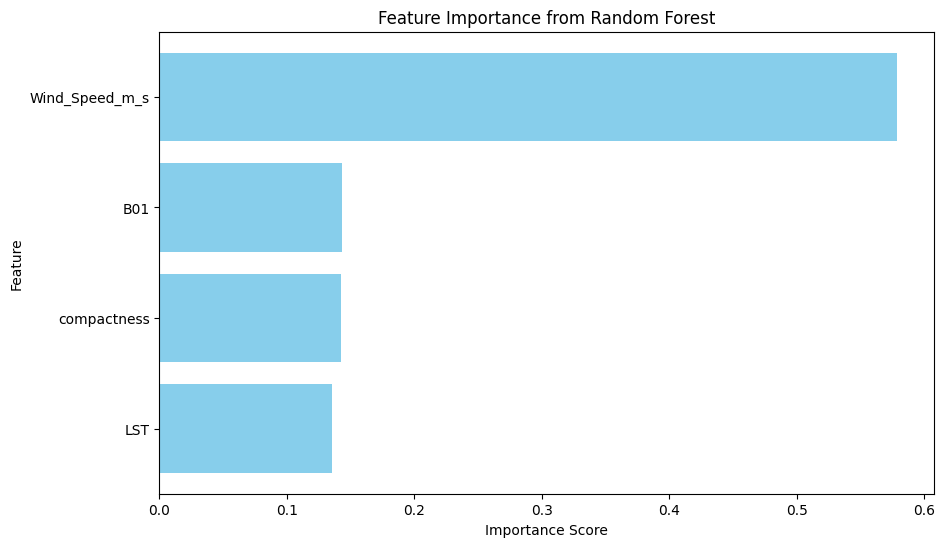

,Feature,Importance
3,Wind_Speed_m_s,0.579102
0,B01,0.143410
2,compactness,0.142364
1,LST,0.135124


In [563]:
# get feature importance 
feature_importance = model.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()
importance_df

In [191]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5,  # Cross-validation splits
                           n_jobs=-1,  # Use all cores for parallel processing
                           verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.6497263689601016


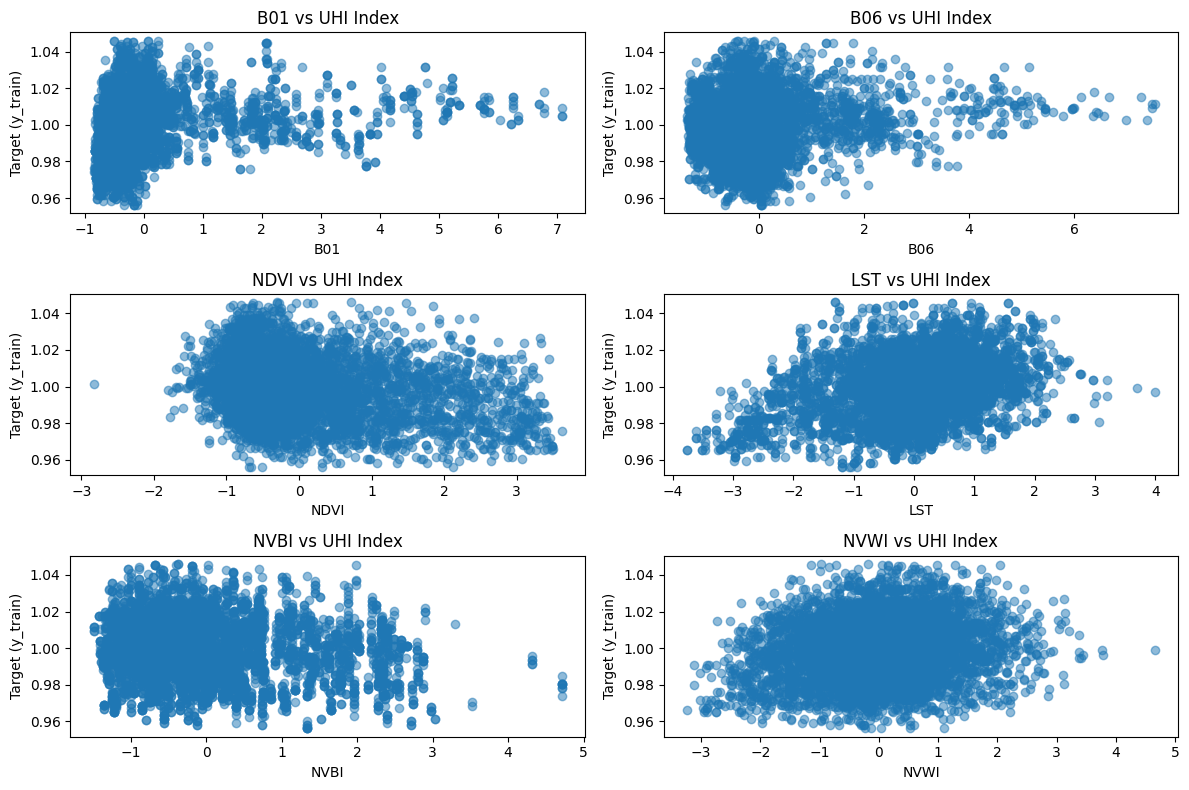

In [237]:
# try to use other ML models like Gradient Boosting 
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(3,2, figsize=(12,8)) 
feature_names = ['B01', 'B06', 'NDVI', 'LST', 'NVBI','NVWI']

# loop through first 6 features 
for i, ax in enumerate(axes.flat):  # Flatten the 2D axes array
    ax.scatter(X_train[:, i], y_train, alpha=0.5)
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel("Target (y_train)")
    ax.set_title(f"{feature_names[i]} vs UHI Index")

plt.tight_layout()
plt.show()

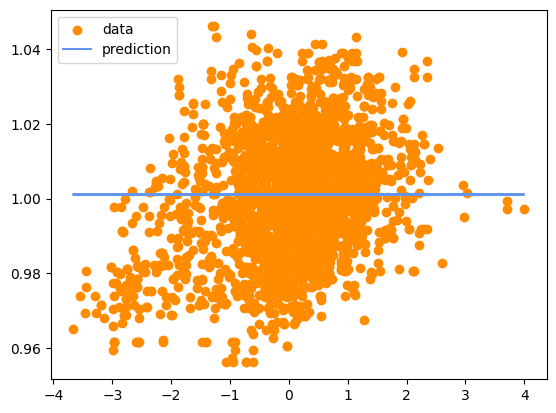

In [57]:
from sklearn.svm import SVR

svr = SVR(kernel ='poly') # radial basis fn kernel 
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

# plot predicted against true values 
plt.scatter(X_test[:, 3], y_test, color='darkorange', 
            label='data') 
plt.plot(X_test[:, 3], y_pred, color='cornflowerblue', 
         label='prediction') 
plt.legend() 
plt.show()



In [58]:
# gradient boosting 
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train) 

# Make predictions
y_pred_train = gbr.predict(X_train)
y_pred_test = gbr.predict(X_test)

# Evaluate the model
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

Train R² Score: 0.3344
Test R² Score: 0.2522


In [133]:
X_train

array([[ 2.22581979,  2.31484714, -0.82757739,  0.23259669, -0.76294103],
       [-0.35119356,  0.37983592,  0.07685773, -0.42897966,  1.38130512],
       [-0.32934324,  0.03705841,  0.98052917, -0.92516192,  2.71943627],
       ...,
       [-0.57168314, -0.90754766, -0.36485949, -0.45121752, -0.5542571 ],
       [-0.48494399,  0.04564574,  3.04163039, -0.5471183 ,  1.85103398],
       [ 2.67209599,  1.89263685, -0.46956258,  0.44524623, -1.33079113]],
      shape=(5852, 5))

In [134]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [61]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42)
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [564]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [565]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9862667106159417

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [566]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [567]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.9041577164554631

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [242]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_template_UHI2025-v2.csv')
test_file.head()
bronx_lat = 40.87248
manhattan_lat = 40.76754
# create new column station in ground_df to determine station for local weatehr data 
test_file['station'] = test_file['Latitude'].apply(lambda x: 'Bronx' if abs(x - bronx_lat) < abs(x - manhattan_lat) else 'Manhattan')
# merge the local weather data together with the ground_df UHI data 
merged_test_data = pd.merge(test_file, weather_data,
                how = 'left', 
                left_on=['station'], 
                right_on = ['station'])
# Display the first few rows of the DataFrame to check the result
print(merged_test_data.head())

   Longitude   Latitude  UHI Index    station         Date / Time  \
0 -73.971665  40.788763        NaN  Manhattan 2021-07-24 06:00:00   
1 -73.971665  40.788763        NaN  Manhattan 2021-07-24 06:05:00   
2 -73.971665  40.788763        NaN  Manhattan 2021-07-24 06:10:00   
3 -73.971665  40.788763        NaN  Manhattan 2021-07-24 06:15:00   
4 -73.971665  40.788763        NaN  Manhattan 2021-07-24 06:20:00   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        21.3                         66.5   
1                        21.4                         66.1   
2                        21.4                         66.5   
3                        21.5                         65.4   
4                        21.5                         65.0   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
0                   0.9                       348                  10   
1                   1.1                       345                 

In [351]:
# Mapping satellite data for submission.
val_data = map_satellite_data('S2_sample2.tiff', 'Submission_template_UHI2025-v2.csv')

Mapping values:   0%|          | 0/1040 [00:00<?, ?it/s]

Mapping values: 100%|██████████| 1040/1040 [00:11<00:00, 90.71it/s]


In [352]:
val_data2 = map_satellite_data1('Landsat_LST.tiff','Submission_template_UHI2025-v2.csv')

Mapping values:   0%|          | 0/1040 [00:00<?, ?it/s]

Mapping values: 100%|██████████| 1040/1040 [00:01<00:00, 538.57it/s]


In [353]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

In [254]:
# Calculate NDBI (Normalized Difference Building Index) and handle division by zero by replacing infinities with NaN.
val_data['NVBI'] = (val_data['B11'] - val_data['B08']) / (val_data['B11'] + val_data['B08'])
val_data['NVBI'] = val_data['NVBI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

In [255]:
# Calculate NDVI (Normalized Difference Water Index) and handle division by zero by replacing infinities with NaN.
val_data['NVWI'] = (val_data['B03'] - val_data['B08']) / (val_data['B03'] + val_data['B08'])
val_data['NVWI'] = val_data['NVWI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

In [580]:
val_data.head()

,B01,B04,B06,B08,B12,B11,NDVI
0,811.0,432.0,2089.0,2502.0,893.0,1474.0,0.705521
1,1208.0,647.0,2076.0,2906.0,1188.0,1751.0,0.635801
2,899.0,1188.0,995.0,1246.0,763.0,1101.0,0.023829
3,1193.0,1512.0,1939.0,1774.0,2346.0,2521.0,0.079732
4,1097.0,1688.0,2204.0,2834.0,1848.0,2248.0,0.253428


In [581]:
val_data2.head()

,LST
0,36.202990279999995
1,36.202990279999995
2,36.069687499999986
3,36.886594280000054
4,34.50081632000001


In [582]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data= val_data.loc[:,['B01']]
submission_val_data.head()

,B01
0,811.0
1,1208.0
2,899.0
3,1193.0
4,1097.0


In [583]:
submission_val_data = combine_two_datasets(submission_val_data, val_data2)

In [584]:
submission_val_data.head()

,B01,LST
0,811.0,36.202990279999995
1,1208.0,36.202990279999995
2,899.0,36.069687499999986
3,1193.0,36.886594280000054
4,1097.0,34.50081632000001


In [585]:
# now map the building compactness feature onto the submission dataset 
submission_template = pd.read_csv("Submission_template_UHI2025-v2.csv")
submission_template.head()
# create geoDataFrame for new dataset (UHI Submission Data)\
submission_uhi = gpd.GeoDataFrame(submission_template, geometry=gpd.points_from_xy(submission_template['Longitude'], submission_template['Latitude']), crs="EPSG:4326")
submission_uhi.head()
centroid_gdf.head()

# perform spatial join for the compactness attribute 
submission_uhi = submission_uhi.sjoin_nearest(centroid_gdf, how='left', distance_col='nearest_distance')
submission_uhi.head()
submission_compactness = submission_uhi['compactness']
submission_compactness.shape
submission_template.shape


(1040, 3)

In [586]:
submission_val_data = pd.DataFrame(submission_val_data)

# Now add the column
submission_val_data['compactness'] = submission_compactness

submission_val_data.head()

,B01,LST,compactness
0,811.0,36.202990279999995,0.000073
1,1208.0,36.202990279999995,0.000125
2,899.0,36.069687499999986,0.000124
3,1193.0,36.886594280000054,0.000077
4,1097.0,34.50081632000001,0.000227


In [587]:
# Haversine Formula: calculate great-circle distance btw 2 points of Earth's surface
# given longitude and latitude 

# Haversine formula to calculate distance between two points on the earth's surface
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Function to calculate weighted average based on proximity to stations
def weighted_weather(row, weather_data):
    # Calculate distances to each station
    distances = []
    for _, station in weather_data.iterrows():
        distance = haversine(row['Latitude'], row['Longitude'], station['Latitude'], station['Longitude'])
        distances.append(distance)
    
    # Inverse of distances (for weighting)
    inverse_distances = [1 / distance if distance > 0 else 0 for distance in distances]
    
    # Normalize the weights (so they sum to 1)
    total_weight = sum(inverse_distances)
    normalized_weights = [weight / total_weight for weight in inverse_distances]
    
    # Compute the weighted averages
    weighted_values = {}
    for col in ['Temp_C', 'Humidity', 'Wind_Speed_m_s', 'Wind_Direction_deg', 'Solar_Flux_W_m2']:
        weighted_values[col] = sum(weather_data[col] * normalized_weights)
    
    return weighted_values

# Apply the weighted average function to each row of the training data
def merge_weather_data(training_data, weather_data):
    weather_data_merged = []
    for _, row in training_data.iterrows():
        weighted_weather_values = weighted_weather(row, weather_data)
        weather_data_merged.append({**row.to_dict(), **weighted_weather_values})
    
    # Convert the result to a DataFrame
    return pd.DataFrame(weather_data_merged)

# Merge the weather data onto the test dataset
merged_data = merge_weather_data(submission_template, weather_data_aggregated)

# View the first few rows of the merged data
merged_data = merged_data[['Temp_C', 'Humidity', 'Wind_Speed_m_s', 'Wind_Direction_deg', 'Solar_Flux_W_m2']]
merged_data_wind_speed = merged_data['Wind_Speed_m_s']

In [588]:
submission_val_data['Wind_Speed_m_s'] = merged_data_wind_speed

submission_val_data.head()

,B01,LST,compactness,Wind_Speed_m_s
0,811.0,36.202990279999995,0.000073,2.994550
1,1208.0,36.202990279999995,0.000125,2.994711
2,899.0,36.069687499999986,0.000124,2.994761
3,1193.0,36.886594280000054,0.000077,2.995024
4,1097.0,34.50081632000001,0.000227,2.993408


In [589]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [590]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [591]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [592]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.963017
1,-73.971928,40.788875,0.964605
2,-73.967080,40.789080,0.963484
3,-73.972550,40.789082,0.967562
4,-73.969697,40.787953,0.959584


In [593]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission13.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>